In [5]:
!pip3 install --upgrade keras-nlp

In [1]:
import platform

import numpy as np
import matplotlib.pyplot as plt

import keras
import keras_nlp
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Sometimes, the learning with tensorflow-metal does not converge.
# @see
# - https://forums.developer.apple.com/forums/thread/736187
# - https://forums.developer.apple.com/forums/thread/701056
# - https://forums.developer.apple.com/forums/thread/742157
# Therefore, it might be best to execute learning without metal and execute learning again in the last tuning phase.
if platform.processor() == "arm":
    print("This is running on M1/M2 mac.")
    tf.config.set_visible_devices([], 'GPU')
print(f"Tensorflow {tf.__version__} is running. This notebook was written with Tensorflow 2.15.0.")
print(f"Keras {keras.__version__} is running. This notebook was written with Keras 2.15.0.") 

This is running on M1/M2 mac.
Tensorflow 2.14.1 is running. This notebook was written with Tensorflow 2.15.0.
Keras 2.14.0 is running. This notebook was written with Keras 2.15.0.


***

In [12]:
def plot(history, title=None):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(["loss", "accuracy"]):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    print(
        np.min(history.history["val_loss"]),
        "The best number of epocs for the validation loss is",
        np.argmin(history.history["val_loss"]) + 1,
    )
    print(
        np.max(history.history["val_accuracy"]),
        "The best number of epocs for the validation accuracy is",
        np.argmax(history.history["val_accuracy"]) + 1,
    )

def load_ag_news_subset(batch_size, shuffle=False):
    """
    Load ag_news_subset dataset.
    :param batch_size: the number of batch size.
    :param shuffle: if True, it is shuffled.
    :return: a dataset object.
    """
    BUFFER_SIZE = 10000
    dataset, info = tfds.load(
        'ag_news_subset',
        with_info=True,
        as_supervised=False
    )
    train_dataset, test_dataset = dataset['train'], dataset['test']

    if shuffle:
        # If shuffle is hopefully used,
        # the reshuffle_each_iteration parameter must be False.
        # Or the partial training dataset and the validation set are contaminated.
        train_dataset = train_dataset.shuffle(
            buffer_size=BUFFER_SIZE,
            reshuffle_each_iteration=False
        )
        test_dataset = test_dataset.shuffle(
            buffer_size=BUFFER_SIZE,
            reshuffle_each_iteration=False
        )

    partial_train_dataset = train_dataset.take(len(train_dataset) // 10 * 8)
    val_dataset = train_dataset.skip(len(train_dataset) // 10 * 8)

    print("The number of training set is", len(train_dataset))
    print("The number of partial training set is", len(partial_train_dataset))
    print("The number of validation set is", len(val_dataset))

    # In advance, batch and prefetch are called. Or, they are needed for each use.
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    partial_train_dataset = partial_train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, partial_train_dataset, val_dataset, test_dataset

def tuplize(x):
    """
    Transform a row from the dataset to learn.
    :param x: a single row of the dataset.
    :return: a tuple of the feature and the target.
    """
    return (
        x['title'] + ' ' + x['description'],# x: feature
        x['label']# y: target
    )

def build_text_vectorization_layer(
        dataset,
        max_tokens=25000,
        output_mode='int',
        sequence_length=50):
    """
    Build a TextVectorization layer for preprocessing of text/token.
    :param dataset: the tokenized text data.
    :param max_tokens: the number of token.
    :param output_mode: for the param of TextVectorization. multi_hot/int is expected.
    :return: a TextVectorization layer.
    """
    vectorization_layer = keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        output_sequence_length=sequence_length
    )
    vectorization_layer.adapt(dataset.map(lambda x: x['description'] + ' ' + x['title']))
    # The test set should not be adapted.
    #vectorization_layer.adapt(test_dataset.map(lambda x: x['description'] + ' ' + x['title']))
    return vectorization_layer

def build_model(
        vectorization_layer: keras.layers.TextVectorization,
        max_tokens=25000,
        embedding_dim=128,
        intermediate_dim=32,
        num_heads=4,
        sequence_length=50,
        name=None):
    if platform.system() == "Darwin" and platform.processor() == "arm":
        """
        Apple Silicon mac shows tht following warning.
        WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
        please use the legacy Keras optimizer instead,
        located at `tf.keras.optimizers.legacy.Adam`
        Therefore, keras.optimizers.legacy.Adam is used.
        """
        optimizer = keras.optimizers.legacy.Adam()
    else:
        optimizer = keras.optimizers.Adam()
    """
    Build a sequential model with the TextVectorization and Embedding.
    :param vectorization_layer: the layer object where sentence is converted to int.
    :param max_tokens: the number of token.
    :param embedding_dim: the number of dimension for embedding.
    :param intermediate_dim: the number of units.
    :param num_heads: the number of heads.
    :param sequence_length: the length of a sequence.
    :param name: the name of the model.
    :return: a sequential model.
    """
    inputs = keras.layers.Input(shape=(1,), dtype="string")
    x = vectorization_layer(inputs)
    x = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=max_tokens,
        sequence_length=sequence_length,
        embedding_dim=embedding_dim,
    )(x)
    x = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=intermediate_dim,
        num_heads=num_heads
    )(inputs=x)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
    )
    return model

The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
47/47 [==============================] - 51s 1s/step - loss: 1.1327 - accuracy: 0.5876 - val_loss: 0.3735 - val_accuracy: 0.8827
Epoch 2/20
47/47 [==============================] - 49s 1s/step - loss: 0.3464 - accuracy: 0.8847 - val_loss: 0.2831 - val_accuracy: 0.9082
Epoch 3/20
47/47 [==============================] - 49s 1s/step - loss: 0.2360 - accuracy: 0.9216 - val_loss: 0.2592 - val_accuracy: 0.9174
Epoch 4/20
47/47 [==============================] - 49s 1s/step - loss: 0.1806 - accuracy: 0.9396 - val_loss: 0.2529 - val_accuracy: 0.9191
Epoch 5/20
47/47 [==============================] - 49s 1s/step - loss: 0.1450 - accuracy: 0.9530 - val_loss: 0.2517 - val_accuracy: 0.9195
Epoch 6/20
47/47 [==============================] - 50s 1s/step - loss: 0.1206 - accuracy: 0.9606 - val_loss: 0.2516 - val_accuracy: 0.9198
Epoch 7/20
47/47 [=======================

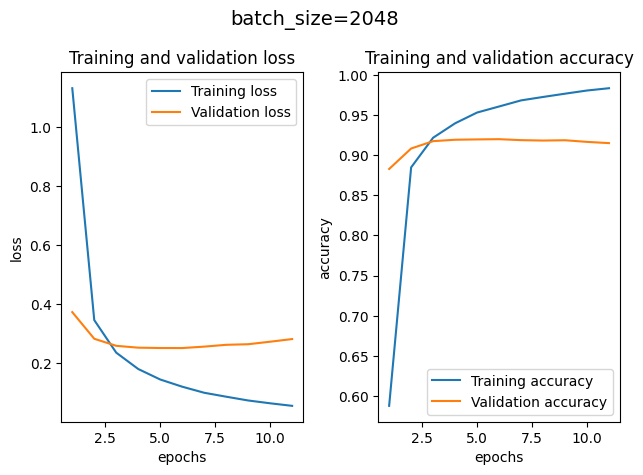

0.2515905797481537 The best number of epocs for the validation loss is 6
0.9198333621025085 The best number of epocs for the validation accuracy is 6
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
94/94 [==============================] - 51s 532ms/step - loss: 0.8686 - accuracy: 0.6925 - val_loss: 0.3119 - val_accuracy: 0.9023
Epoch 2/20
94/94 [==============================] - 50s 531ms/step - loss: 0.2820 - accuracy: 0.9078 - val_loss: 0.2599 - val_accuracy: 0.9141
Epoch 3/20
94/94 [==============================] - 50s 529ms/step - loss: 0.1977 - accuracy: 0.9348 - val_loss: 0.2518 - val_accuracy: 0.9181
Epoch 4/20
94/94 [==============================] - 52s 553ms/step - loss: 0.1488 - accuracy: 0.9503 - val_loss: 0.2564 - val_accuracy: 0.9163
Epoch 5/20
94/94 [==============================] - 51s 545ms/step - loss: 0.1183 - accuracy: 0.9603 - val_loss: 0.2592 - val_accuracy: 0.9185
Epoch 6/20
94/94

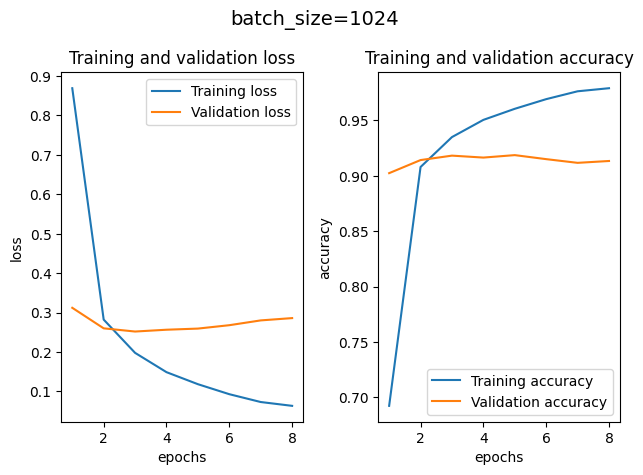

0.2517711818218231 The best number of epocs for the validation loss is 3
0.918541669845581 The best number of epocs for the validation accuracy is 5
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
188/188 [==============================] - 1031s 6s/step - loss: 0.6454 - accuracy: 0.7694 - val_loss: 0.2785 - val_accuracy: 0.9103
Epoch 2/20
188/188 [==============================] - 7215s 33s/step - loss: 0.2381 - accuracy: 0.9216 - val_loss: 0.2666 - val_accuracy: 0.9126
Epoch 3/20
188/188 [==============================] - 6380s 34s/step - loss: 0.1690 - accuracy: 0.9430 - val_loss: 0.2565 - val_accuracy: 0.9163
Epoch 4/20
188/188 [==============================] - 3715s 20s/step - loss: 0.1240 - accuracy: 0.9576 - val_loss: 0.2589 - val_accuracy: 0.9168
Epoch 5/20
188/188 [==============================] - 4248s 23s/step - loss: 0.0902 - accuracy: 0.9690 - val_loss: 0.2785 - val_accuracy: 0.9137
Epoch 6/

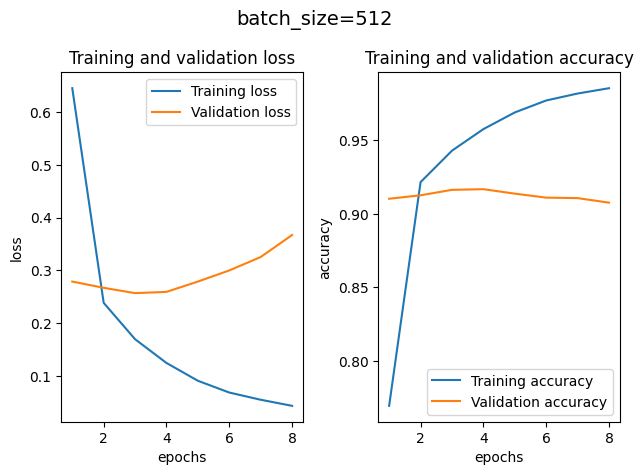

0.2565324604511261 The best number of epocs for the validation loss is 3
0.9167916774749756 The best number of epocs for the validation accuracy is 4
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
375/375 [==============================] - 57s 150ms/step - loss: 0.4865 - accuracy: 0.8242 - val_loss: 0.2540 - val_accuracy: 0.9164
Epoch 2/20
375/375 [==============================] - 55s 147ms/step - loss: 0.2082 - accuracy: 0.9295 - val_loss: 0.2428 - val_accuracy: 0.9176
Epoch 3/20
375/375 [==============================] - 53s 143ms/step - loss: 0.1360 - accuracy: 0.9530 - val_loss: 0.2758 - val_accuracy: 0.9153
Epoch 4/20
375/375 [==============================] - 54s 144ms/step - loss: 0.0942 - accuracy: 0.9668 - val_loss: 0.3062 - val_accuracy: 0.9139
Epoch 5/20
375/375 [==============================] - 53s 142ms/step - loss: 0.0692 - accuracy: 0.9753 - val_loss: 0.3407 - val_accuracy: 0.9103
Epoch 

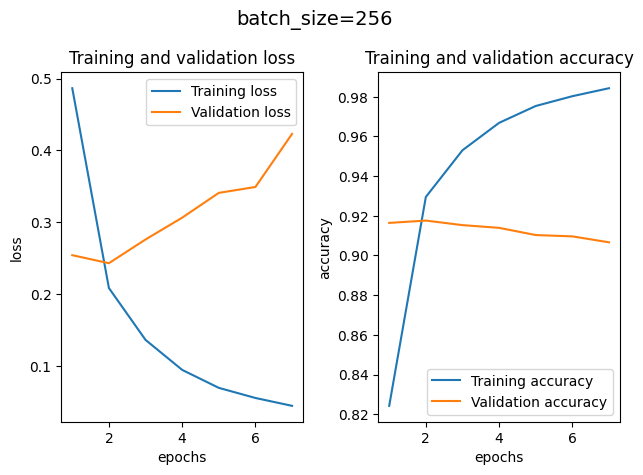

0.2427586317062378 The best number of epocs for the validation loss is 2
0.9175833463668823 The best number of epocs for the validation accuracy is 2
The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
750/750 [==============================] - 77s 101ms/step - loss: 0.4446 - accuracy: 0.8417 - val_loss: 0.2494 - val_accuracy: 0.9155
Epoch 2/20
750/750 [==============================] - 79s 105ms/step - loss: 0.1968 - accuracy: 0.9318 - val_loss: 0.2567 - val_accuracy: 0.9179
Epoch 3/20
750/750 [==============================] - 77s 103ms/step - loss: 0.1264 - accuracy: 0.9553 - val_loss: 0.3011 - val_accuracy: 0.9156
Epoch 4/20
750/750 [==============================] - 75s 100ms/step - loss: 0.0855 - accuracy: 0.9689 - val_loss: 0.3496 - val_accuracy: 0.9133
Epoch 5/20
750/750 [==============================] - 74s 99ms/step - loss: 0.0628 - accuracy: 0.9773 - val_loss: 0.3857 - val_accuracy: 0.9128
Epoch 6

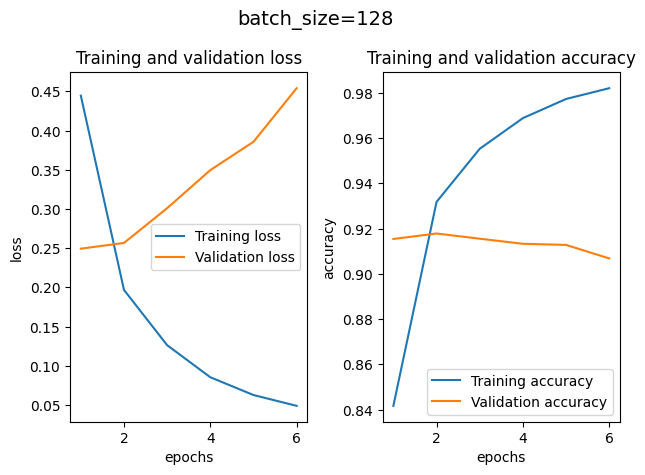

0.24943865835666656 The best number of epocs for the validation loss is 1
0.9178749918937683 The best number of epocs for the validation accuracy is 2


In [13]:
VOCAB_SIZE = 25000
BATCH_SIZE = 1024
NUM_HEADS = 4
INTERMEDIATE_DIM = 64
SEQ_LENGTH = 100

for batch_size in [2048, 1024, 512, 256, 128]:
    train_dataset, partial_train_dataset, val_dataset, test_dataset = load_ag_news_subset(
        batch_size=batch_size
    )
    vectorization_layer = build_text_vectorization_layer(
        dataset=train_dataset,
        max_tokens=VOCAB_SIZE,
        output_mode='int',
        sequence_length=SEQ_LENGTH
    )
    model = build_model(
        vectorization_layer,
        max_tokens=VOCAB_SIZE,
        intermediate_dim=INTERMEDIATE_DIM,
        num_heads=NUM_HEADS,
        sequence_length=SEQ_LENGTH
    )
    history = model.fit(
        partial_train_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
        validation_data=val_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
        epochs=20,
        batch_size=batch_size,
        verbose=1,
        callbacks =[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        ]
    )
    plot(history=history, title=f"batch_size={batch_size}")